# Fluctuating Intensities
## Read file from OMERO and analyse fluctuations of pixel intensities
Laura Cooper 19/05/2020

# 1. Connect to OMERO

In [236]:
#Import packages
from omero.gateway import BlitzGateway
import getpass
import numpy as np
from scipy import fft, ndimage
import matplotlib.pyplot as plt

In [79]:
username = input('Username: ') #Request user to enter OMERO username
password = getpass.getpass(prompt='Password: ') #Request user to enter OMERO password
conn = BlitzGateway(username, password, host='camdu.warwick.ac.uk', port=4064) #Use details to connect to OMERO server
conn.connect() #Returns true when connected

Username: u1675160
Password: ········


True

In [90]:
print("Member of:")
for g in conn.getGroupsMemberOf():
    print("   ID:", g.getName(), " Name:", g.getId())
group = conn.getGroupFromContext()
print("Current group: ", group.getName())
# List the group owners and other members
owners, members = group.groupSummary()
print("   Group owners:")
for o in owners:
    print("     ID: %s %s Name: %s" % (
        o.getId(), o.getOmeName(), o.getFullName()))
    print("   Group members:")
for m in members:
    print("     ID: %s %s Name: %s" % (
        m.getId(), m.getOmeName(), m.getFullName()))

Member of:
   ID: system  Name: 0
   ID: default  Name: 3
   ID: camdu  Name: 153
   ID: lattice  Name: 453
   ID: Royle_Cooper  Name: 1003
Current group:  Royle_Cooper
   Group owners:
     ID: 3 mlsmaf Name: Stephen Royle
   Group members:
     ID: 3052 u1675160 Name: Laura Cooper


In [121]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()
    ))

In [127]:
print("\nList Datasets: \n", "=" * 50)
datasets = conn.getObjects("Dataset", opts={'owner': 3})
for dataset in datasets:
    print_obj(dataset, 2)
    for image in dataset.listChildren():
        print_obj(image, 4)


List Datasets: 
  Dataset:8202  Name:"ER" (owner=mlsmaf)
    Image:245956  Name:"200114HeLa_GFP-Rab15 10-1.tif" (owner=mlsmaf)
    Image:245951  Name:"200114HeLa_GFP-Rab15 10-2.tif" (owner=mlsmaf)
    Image:245961  Name:"200114HeLa_GFP-Rab15 10-3.tif" (owner=mlsmaf)
    Image:245953  Name:"200114HeLa_GFP-Rab15 10-4.tif" (owner=mlsmaf)
    Image:245957  Name:"200114HeLa_GFP-Rab15 8-1.tif" (owner=mlsmaf)
    Image:245955  Name:"200114HeLa_GFP-Rab15 8-2.tif" (owner=mlsmaf)
    Image:245962  Name:"200114HeLa_GFP-Rab15 8-3.tif" (owner=mlsmaf)
    Image:245954  Name:"200114HeLa_GFP-Rab15 8-4.tif" (owner=mlsmaf)
    Image:245949  Name:"200114HeLa_GFP-Rab17 3-1.tif" (owner=mlsmaf)
    Image:245948  Name:"200114HeLa_GFP-Rab17 3-2.tif" (owner=mlsmaf)
    Image:245959  Name:"200114HeLa_GFP-Rab17 3-3.tif" (owner=mlsmaf)
    Image:245947  Name:"200114HeLa_GFP-Rab17 3-4.tif" (owner=mlsmaf)
    Image:245958  Name:"200114HeLa_GFP-Rab17 7-1.tif" (owner=mlsmaf)
    Image:245950  Name:"200114HeLa_GFP-Ra

In [141]:
image = conn.getObject("Image", 245956)
print(" Name:", image.getName())
print(" X:", image.getSizeX())
print(" Y:", image.getSizeY())
print(" Z:", image.getSizeZ())
print(" C:", image.getSizeC())
print(" T:", image.getSizeT())

 Name: 200114HeLa_GFP-Rab15 10-1.tif
 X: 20
 Y: 20
 Z: 30
 C: 1
 T: 1


In [130]:
def get_z_stack(img, c=0, t=0):
    zct_list = [(z, c, t) for z in range(img.getSizeZ())]
    pixels = image.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))

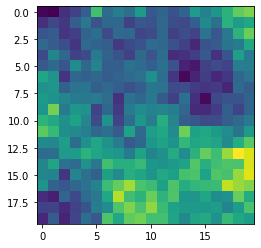

In [147]:
f = get_z_stack(image)
plt.imshow(f[0,:,:])
plt.show()

In [146]:
np.shape(f)

(30, 20, 20)

In [152]:
# mean velocity
u_bar=np.mean(f, axis = 0);
# turbulent fluctuations
u_fluct=np.subtract(f,u_bar)

(30, 20, 20)


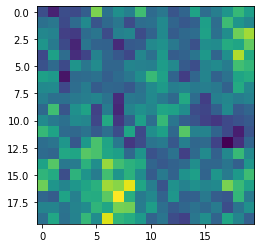

In [155]:
#Turblence Strength
u_rms=

In [181]:
v = f[:,10,10]
t = range(0,30)

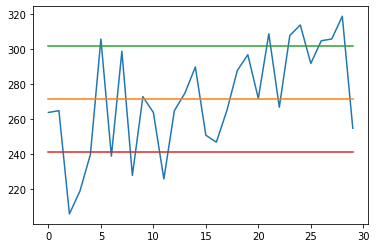

In [186]:
plt.plot(t,v)
plt.plot(t,np.mean(v)*np.ones(30))
plt.plot(t,(np.std(v_fluct)+np.mean(v))*np.ones(30))
plt.plot(t,(-np.std(v_fluct)+np.mean(v))*np.ones(30))
plt.show()

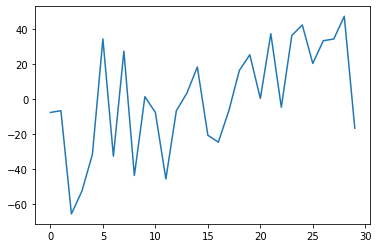

In [173]:
v_fluct=v-np.mean(v)
plt.plot(v_fluct)

In [183]:
#Turbulence strength
np.std(v_fluct)

30.203090349609372

In [187]:
#Turbulence Intensity
np.std(v_fluct)/np.mean(v)

0.1111224810508071

<function matplotlib.pyplot.show(*args, **kw)>

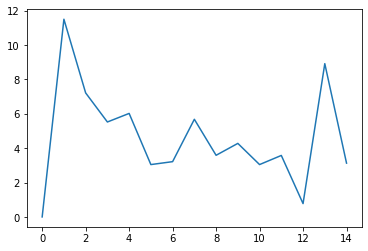

In [216]:
Y=fft.fft(v_fluct); # Fourier transform of function
P2=abs(Y/30) #2 sided spectrum
P1=P2[0:15]
plt.plot(P1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

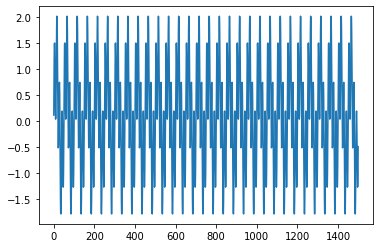

In [334]:
# Create a signal with some noise
#np.random.seed(10)
Fs=1000; #Sample freqency
L=1500 # Length of signal
T = 1/Fs; #Sampling period   
t=np.arange(0,L,1)*T # Time Vector
Hz1=20; #Signal 1\n",
Hz2=80; #Signal 2\n",
F=np.sin(2*np.pi*Hz1*t)+np.sin(2*np.pi*Hz2*t)+(np.random.randint(len(t)))/10000
plt.plot(1000*t,F)
plt.show

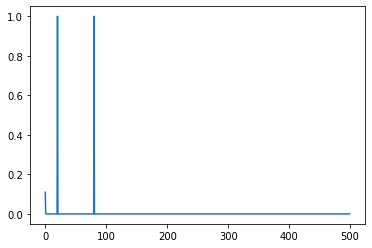

In [335]:
Y=fft.fft(F); # Fourier transform of function\n",
P2=abs(Y/L) #2 sided spectrum\n",
P1=P2[0:int(L/2)]; #1 sided spectrum\n",
P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
fd=Fs*np.arange(0,L/2,1)/L; #Freqency fomain\n",
plt.plot(fd,P1)

In [238]:
np.sin(2*np.pi*Hz1*t)

array([ 0.        , -0.64627349,  0.98635019, -0.85910577,  0.32482713,
        0.36335079, -0.87937737,  0.97876529, -0.61442572, -0.04102153,
        0.67703327, -0.9922746 ,  0.83738789, -0.28575664, -0.40126275,
        0.89816856, -0.96953266,  0.58154359,  0.08197401, -0.70665328,
        0.99652853, -0.81426028,  0.24620508,  0.4384992 , -0.91544771,
        0.95866785, -0.54768244, -0.12278848,  0.73508366, -0.99910484,
        0.78976189, -0.20623904, -0.47499745,  0.93118572, -0.94618915,
        0.51289928,  0.16339624, -0.76227654,  0.99999918, -0.76393395,
        0.1659258 ,  0.51069605, -0.94535611,  0.93211756, -0.47725267,
       -0.20372893,  0.78818616, -0.99921004,  0.73681996, -0.12533323])

In [310]:
print(L)
np.arange(0,L,1)

1500


array([   0,    1,    2, ..., 1497, 1498, 1499])